### This code implements LASSO and Ridge regularization techniques for portfolio optimization and linear regression. I'll break it down into conceptual components and provide detailed mathematical explanations.


1. Portfolio Optimization Framework

The code begins by implementing three different regression approaches for portfolio optimization:

a) Normal Linear Regression:
```python
reg = LinearRegression(fit_intercept=False).fit(df.drop(["label"], axis=1), df["label"])
```

b) LASSO Regression:
```python
reg = Lasso(fit_intercept=False, alpha=0.0005, positive=True).fit(df.drop(["label"], axis=1), df["label"])
```

c) Ridge Regression:
```python
reg = Ridge(fit_intercept=False, alpha=1).fit(df.drop(["label"], axis=1), df["label"])
```

Let me visualize how these different regularization approaches affect portfolio weights:

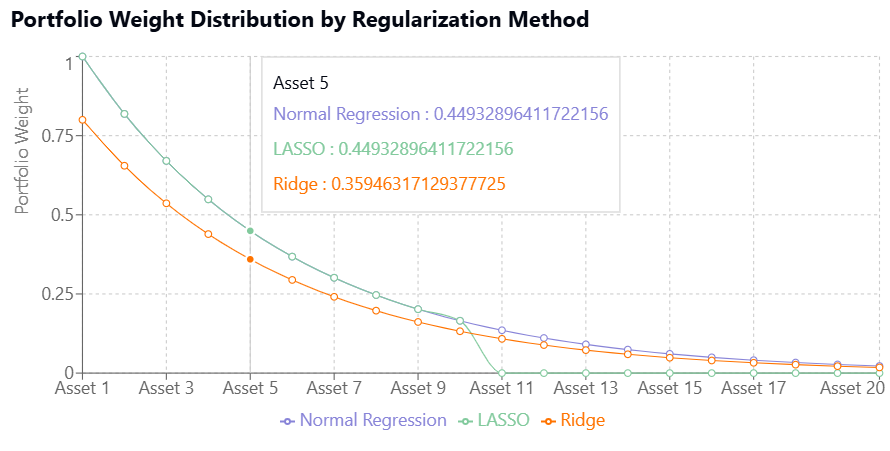


2. Mathematical Framework

The code implements three key optimization problems:

a) Normal Linear Regression:
$$\min_{\beta} \|X\beta - y\|^2_2$$

b) LASSO (L1 regularization):
$$\min_{\beta} \|X\beta - y\|^2_2 + \alpha\|\beta\|_1$$

c) Ridge (L2 regularization):
$$\min_{\beta} \|X\beta - y\|^2_2 + \alpha\|\beta\|^2_2$$

Let me visualize how these regularization terms affect the optimization landscape:


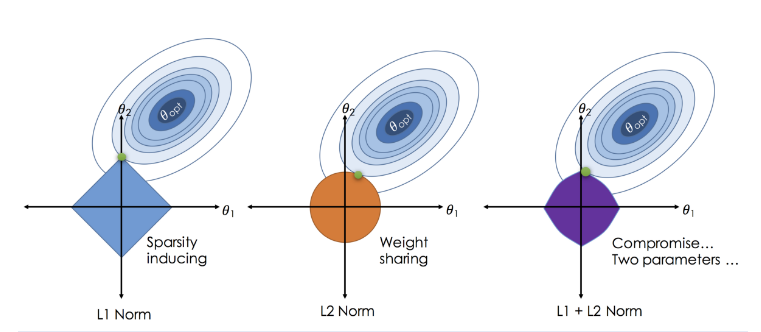


3. Model Training and Validation

The code implements a rolling window approach for portfolio optimization:

```python
years_lookback = 5
reg_periods = df.shape[0]-(12*years_lookback)

for n in range(len(df)-reg_periods-1):
    df_reg = df.iloc[n:reg_periods+n,:].copy()
    # Train models and calculate weights
```

4. Performance Evaluation

The code calculates several key metrics:

a) Portfolio Returns:
$$R_p = \sum_{i=1}^n w_i R_i$$

b) Cumulative Returns:
$$R_{cum} = \prod_{t=1}^T (1 + R_t)$$

5. Early Stopping and Cross-Validation

The code implements early stopping for gradient descent:
```python
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True)
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    val_error = mean_squared_error(y_val, y_val_predict)
```

This implements early stopping criterion:
$$\text{Stop when } \text{Validation Error}_t > \text{Validation Error}_{t-1}$$

6. Polynomial Features and Regularization

The code creates polynomial features and applies regularization:
```python
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
```

The polynomial expansion is:
$$X_{poly} = [x, x^2, ..., x^d]$$

Key References:
1. Tibshirani, R. (1996) "Regression Shrinkage and Selection via the Lasso"
2. Hoerl, A.E. and Kennard, R.W. (1970) "Ridge Regression: Biased Estimation for Nonorthogonal Problems"
3. DeMiguel et al. (2009) "A Generalized Approach to Portfolio Optimization"

The code provides several important innovations:
1. Combines financial theory with modern machine learning
2. Implements robust regularization for portfolio stability
3. Uses rolling windows for dynamic rebalancing
4. Provides comprehensive performance metrics

# Setup

In [0]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../.."
CHAPTER_ID = "training_linear_models"


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format='png', dpi=300)
    except:
        plt.savefig(fig_id + ".png", format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear regression using the Normal Equation

In [0]:
from pathlib import Path
import pandas as pd
import numpy as np

my_file = Path("returns.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('returns.csv')
    rf = pd.read_csv('rf.csv')
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'returns.csv')
    rf = pd.read_csv(github_p+'rf.csv')
    
    print("Done")
df = df.set_index("date",drop=True)
df.head()

Local file found


,A,AAME,AAON,AAP,AAPL,AAWW,ABC,ABCB,ABG,ABM,...,YORW,YRCW,YUM,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZN,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
20071231,-0.028813,-0.200000,0.049921,0.058120,0.087038,0.029820,-0.011020,0.009507,-0.100956,-0.000490,...,-0.015684,-0.035008,0.030148,-0.100337,0.213083,-0.144402,0.038123,0.179487,0.032747,-0.123741
20080131,-0.078389,0.135714,-0.101917,-0.058173,-0.316640,-0.078938,0.038110,-0.063502,-0.055149,0.022315,...,-0.005161,0.071387,-0.103475,-0.114986,0.065595,0.172414,-0.067797,-0.226087,-0.060100,-0.210591
20080229,-0.095983,-0.025157,-0.072472,-0.062605,-0.076389,0.013216,-0.102727,-0.098859,0.001758,-0.041506,...,0.006550,-0.248498,0.008489,0.084989,0.223439,-0.119839,-0.063636,0.101124,-0.014324,-0.085803
20080331,-0.025482,-0.012903,0.213204,0.016995,0.147816,0.086957,-0.017737,0.139240,-0.018545,0.129909,...,-0.025325,-0.046512,0.080116,0.000000,0.092010,-0.046073,-0.048544,-0.012755,0.008081,-0.107509
20080430,0.012739,0.555556,-0.097354,0.018502,0.212195,0.103273,-0.010493,-0.067248,0.210029,-0.061275,...,0.057961,0.238567,0.097286,0.102941,0.135255,0.017563,0.040816,-0.018088,0.024000,0.335245


In [0]:
from sklearn.linear_model import LinearRegression
df["label"] = 1 
reg = LinearRegression(fit_intercept=False).fit(df.drop(["label"],axis=1), df["label"])

df_coeff = pd.DataFrame(df.drop(["label"],axis=1).columns)
df_coeff.columns = ["TICKER"]
df_coeff["coeff"] = reg.coef_
df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum())*100

print("Normal Regression Weights")
df_coeff[df_coeff["weight"]>0.1].head(5)   ### Stocks where portfolio weights are more thn 0.1%

Normal Regression Weights


,TICKER,coeff,weight
8,ABG,0.159363,0.149399
10,ABMD,0.227337,0.213124
12,ACAD,0.138325,0.129677
13,ACET,-0.110286,0.103391
36,AES,-0.107767,0.101029


In [0]:
from sklearn.linear_model import Lasso
df["label"] = 1 
reg = Lasso(fit_intercept=False,alpha=0.0005, positive=True).fit(df.drop(["label"],axis=1), df["label"])

df_coeff = pd.DataFrame(df.drop(["label"],axis=1).columns)
df_coeff.columns = ["TICKER"]
df_coeff["coeff"] = reg.coef_
df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum())*100


print("Lasso Regression Weights, alpha=0.0005")
df_coeff[df_coeff["weight"]>1].head(5) ### Stocks where portfolio weights are more thn 1%

Lasso Regression Weights, alpha=0.0005


,TICKER,coeff,weight
255,CACC,0.827974,3.474682
311,CHD,1.019468,4.278307
326,CIZN,0.363135,1.523936
373,CPK,0.680863,2.857315
493,DLTR,1.444784,6.063195


In [0]:
from sklearn.linear_model import Ridge
df["label"] = 1 
reg = Ridge(fit_intercept=False,alpha=1).fit(df.drop(["label"],axis=1), df["label"])

df_coeff = pd.DataFrame(df.drop(["label"],axis=1).columns)
df_coeff.columns = ["TICKER"]
df_coeff["coeff"] = reg.coef_
df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum())*100

print("Ridge Regression Weights")
df_coeff[df_coeff["weight"]>0.1].head(5) ### Stocks where portfolio weights are more thn 0.1%

Ridge Regression Weights


,TICKER,coeff,weight
8,ABG,0.141935,0.148249
10,ABMD,0.207163,0.216379
12,ACAD,0.123340,0.128827
13,ACET,-0.100802,0.105286
38,AEY,-0.123495,0.128989


In [0]:
### Each month, calculate the weight and the portfolios, choosing Lasso
### Use 5 years data and roll forward, monthtly basis

In [0]:
df.head()

,A,AAME,AAON,AAP,AAPL,AAWW,ABC,ABCB,ABG,ABM,...,YRCW,YUM,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZN,ZUMZ,label
date,,,,,,,,,,,,,,,,,,,,,
20071231,-0.028813,-0.200000,0.049921,0.058120,0.087038,0.029820,-0.011020,0.009507,-0.100956,-0.000490,...,-0.035008,0.030148,-0.100337,0.213083,-0.144402,0.038123,0.179487,0.032747,-0.123741,1
20080131,-0.078389,0.135714,-0.101917,-0.058173,-0.316640,-0.078938,0.038110,-0.063502,-0.055149,0.022315,...,0.071387,-0.103475,-0.114986,0.065595,0.172414,-0.067797,-0.226087,-0.060100,-0.210591,1
20080229,-0.095983,-0.025157,-0.072472,-0.062605,-0.076389,0.013216,-0.102727,-0.098859,0.001758,-0.041506,...,-0.248498,0.008489,0.084989,0.223439,-0.119839,-0.063636,0.101124,-0.014324,-0.085803,1
20080331,-0.025482,-0.012903,0.213204,0.016995,0.147816,0.086957,-0.017737,0.139240,-0.018545,0.129909,...,-0.046512,0.080116,0.000000,0.092010,-0.046073,-0.048544,-0.012755,0.008081,-0.107509,1
20080430,0.012739,0.555556,-0.097354,0.018502,0.212195,0.103273,-0.010493,-0.067248,0.210029,-0.061275,...,0.238567,0.097286,0.102941,0.135255,0.017563,0.040816,-0.018088,0.024000,0.335245,1


Lasso


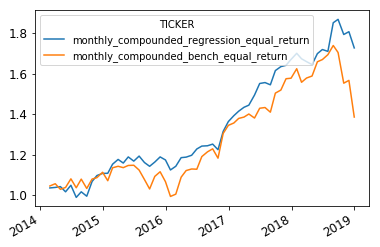

In [0]:
from sklearn.linear_model import Lasso

years_lookback = 5 
reg_periods = df.shape[0]-(12*years_lookback)


reg_type="Lasso"  
#reg_type = "Normal"

print(reg_type)

for n in range(len(df)-reg_periods-1):
    df_reg = df.iloc[n:reg_periods+n,:].copy()
    weight_date = df.iloc[reg_periods+n+1].copy().name
    df_reg["label"] = 1 
    if reg_type == "Lasso":
        reg = Lasso(fit_intercept=False,alpha=0.0005, positive=True,random_state=22).fit(df_reg.drop(["label"],axis=1), df_reg["label"])
    elif reg_type == "Normal":
        reg = LinearRegression(fit_intercept=False).fit(df.drop(["label"],axis=1), df["label"])
    else:
        print("please set reg = to Lasso or Normal")
        break
    
    df_coeff = pd.DataFrame(df_reg.drop(["label"],axis=1).columns)
    df_coeff.columns = ["TICKER"]
    df_coeff["coeff"] = reg.coef_
    df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum())*100
    df_coeff[weight_date] = df_coeff["weight"]/100

    df_coeff = df_coeff.set_index("TICKER")

    df_coeff = df_coeff[[weight_date]].T
    df_coeff = df_coeff.replace(0., np.nan)

    if n ==0:
        df_all = df_coeff
    else:
        df_all = pd.concat((df_all,df_coeff),axis=0)

df_all.head()

df_ret = df.loc[df_all.index[0]:].drop("label",axis=1) # select returns of original dataframe to match weights dataframe

df_port_returns = df_all*df_ret.values

df_port_returns["monthly_returns"] = df_port_returns.sum(axis=1) # equal weighted returns

df_port_returns["monthly_compounded_regression_equal_return"]= ((df_port_returns["monthly_returns"]+1).cumprod())


##bench
df_port_returns["monthly_returns_bench_equal"] = df_ret.mean(axis=1) # equal weighted returns

df_port_returns["monthly_compounded_bench_equal_return"]= ((df_port_returns["monthly_returns_bench_equal"]+1).cumprod())

df_port_returns.index = pd.to_datetime(df_port_returns.index, format='%Y%m%d')
                                       
df_port_returns[["monthly_compounded_regression_equal_return","monthly_compounded_bench_equal_return"]].plot.line()


### This part forward follows the original notebook

In [0]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


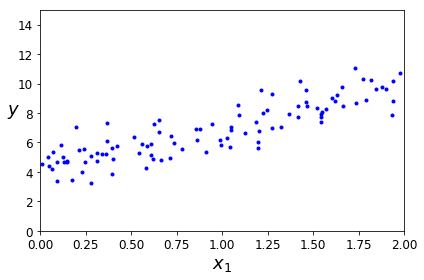

In [0]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [0]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [0]:
theta_best

array([[4.20831857],
       [2.79226572]])

In [0]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.20831857],
       [9.79285   ]])

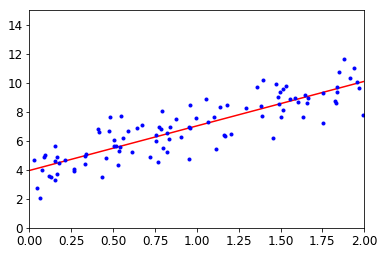

In [0]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The figure in the book actually corresponds to the following code, with a legend and axis labels:

Saving figure linear_model_predictions


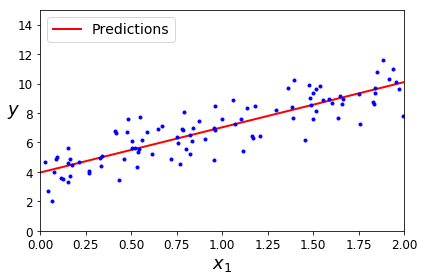

In [0]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions")
plt.show()

In [0]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.95574706]), array([[3.073125]]))

In [0]:
lin_reg.predict(X_new)

array([[ 3.95574706],
       [10.10199706]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [0]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.95574706],
       [3.073125  ]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [0]:
np.linalg.pinv(X_b).dot(y)

array([[3.95574706],
       [3.073125  ]])

**Note**: the first releases of the book implied that the `LinearRegression` class was based on the Normal Equation. This was an error, my apologies: as explained above, it is based on the pseudoinverse, which ultimately relies on the SVD matrix decomposition of $\mathbf{X}$ (see chapter 8 for details about the SVD decomposition). Its time complexity is $O(n^2)$ and it works even when $m < n$ or when some features are linear combinations of other features (in these cases, $\mathbf{X}^T \mathbf{X}$ is not invertible so the Normal Equation fails), see [issue #184](https://github.com/ageron/handson-ml/issues/184) for more details. However, this does not change the rest of the description of the `LinearRegression` class, in particular, it is based on an analytical solution, it does not scale well with the number of features, it scales linearly with the number of instances, all the data must fit in memory, it does not require feature scaling and the order of the instances in the training set does not matter.

# Linear regression using batch gradient descent

In [0]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [0]:
theta

array([[3.95574706],
       [3.073125  ]])

In [0]:
X_new_b.dot(theta)

array([[ 3.95574706],
       [10.10199706]])

In [0]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


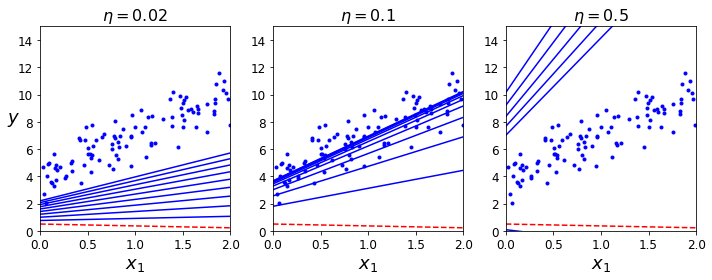

In [0]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

# Stochastic Gradient Descent

In [0]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


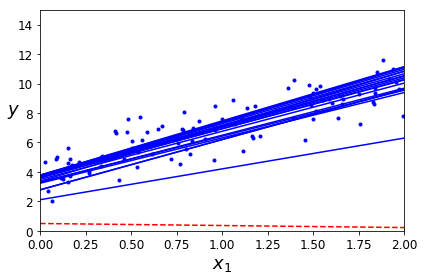

In [0]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

In [0]:
theta

array([[3.92793287],
       [3.06981492]])

In [0]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=42, shuffle=True, tol=-inf, verbose=0,
       warm_start=False)

In [0]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.88184084]), array([2.96620713]))

# Mini-batch gradient descent

In [0]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [0]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [0]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


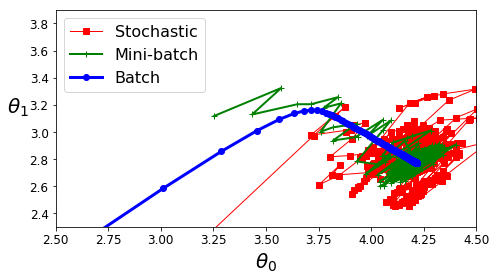

In [0]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial regression

In [0]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [0]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


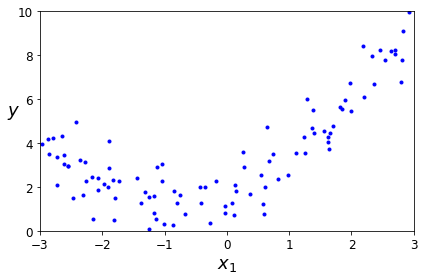

In [0]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [0]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


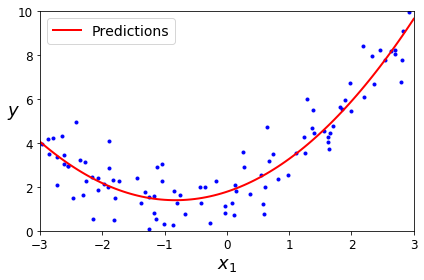

In [0]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

Saving figure high_degree_polynomials_plot


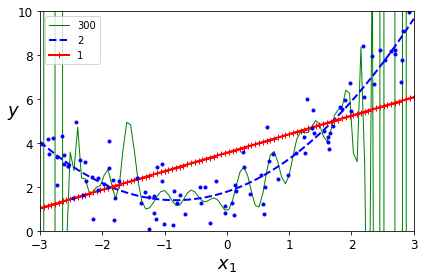

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


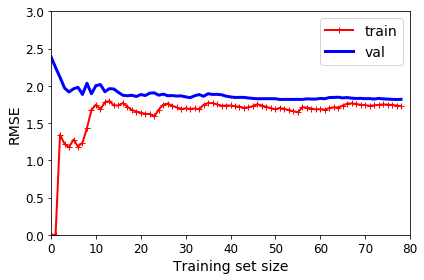

In [0]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

Saving figure learning_curves_plot


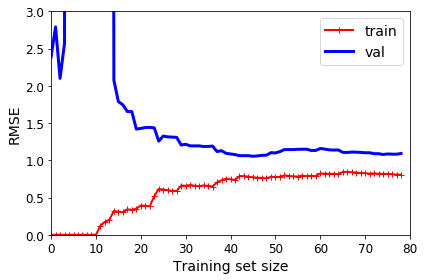

In [0]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

# Regularized models

Saving figure ridge_regression_plot


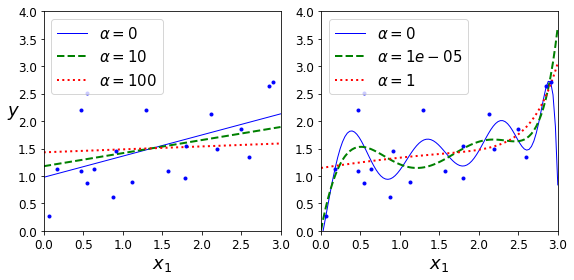

In [0]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [0]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [0]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.49905184])

In [0]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

Saving figure lasso_regression_plot


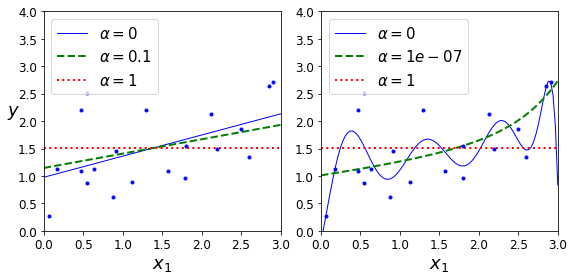

In [0]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [0]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [0]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

Saving figure early_stopping_plot


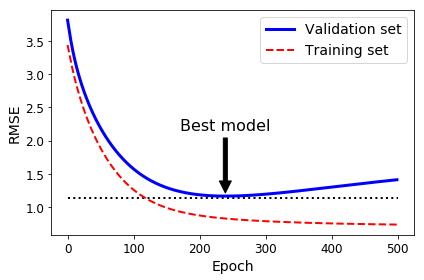

In [0]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [0]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [0]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
        verbose=0, warm_start=True))

In [0]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


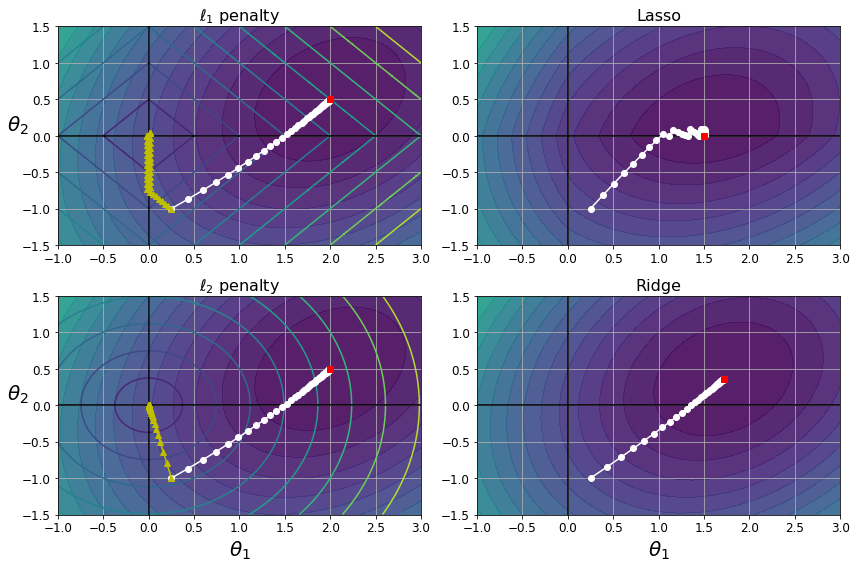

In [0]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

save_fig("lasso_vs_ridge_plot")
plt.show()